# B2B Pricing Optimization

This project aims to optimize contract discount for each company to maximize the total contract revenue.

- We first built several logistic regression models to predict the probability of contract win using historical data.

- Then we applied pricing optimization model for using each prediction model results to find the best-performing one.

- By comparing the evaluation metric (optimized revenue/ actual revenue ratio), we determined best-performing optimization model, which leads to 61.2% revenue increase in the hold-out sample.

## Data Preparation

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.optimize import minimize
import math
import scipy
import scipy.stats as stats
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from sklearn import preprocessing
import seaborn as sns
import pandas as pd
import numpy as np 

url = 'https://raw.githubusercontent.com/ormarketing/b2b/master/data.csv'
df = pd.read_csv(url)
df.head()

,ID,Close Date,Created Date,New Logo,Type,Stage,Billing Plan,ACV,Discount Amount,Amount,Net Amount
0,1,5/26/17,5/4/17,1,Direct - Cloud Product,Closed Lost,3 Years,431370,,225000,225000
1,2,12/29/16,11/29/16,1,Partner - OnPremise Product,Closed Won - Paid,3 Years,22050,80850,147000,66150
2,3,12/29/16,12/9/16,1,Partner - Cloud Product,Closed Won - Paid,3 Years,32750,43200,96000,52800
3,4,9/9/16,4/20/16,1,Direct - Cloud Product,Closed Won - Paid,4 Years,36694,44800,128000,83200
4,5,9/22/16,9/1/16,1,Partner - OnPremise Product,Closed Won - Paid,3 Years,18700,9900,66000,56100


In [129]:
df['Partner cloud']=np.where(df['Type'] =='Partner - Cloud Product', 1.0,0.0)
df['Partner prem']=np.where(df['Type'] =='Partner - OnPremise Product', 1.0, 0.0)
df['Direct cloud']=np.where(df['Type'] =='Direct - Cloud Product', 1.0,0.0)
df['Direct prem']=np.where(df['Type'] =='Direct - OnPremise Product', 1.0, 0.0)
df['amount']=pd.to_numeric(df[' Amount '],errors='coerce')
df['acv']=pd.to_numeric(df[' ACV '],errors='coerce')
df['net amount']=pd.to_numeric(df[' Net Amount '],errors='coerce')
df['billing plan year']=pd.to_numeric(df['Billing Plan'].astype(str).str[0],errors='coerce') #turn billing plan to a bumber
df['discount']=df['amount']-df['net amount']
df['depth']=df['discount']/df['amount']
df.drop(' Discount Amount ',axis=1)
df.drop([' ACV ',' Discount Amount ',' Amount ', ' Net Amount ', 'ID', 'Type'],axis=1);

## EDA

Lost    971
Won     534
Name: Stage, dtype: int64

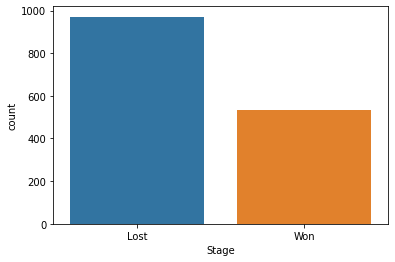

In [130]:
# Check the number of lost and won contract
df['Stage']=np.where(df['Stage'] =='Closed Lost', 'Lost', df['Stage'])
df['Stage']=np.where(df['Stage'] =='Closed Won - Paid', 'Won', df['Stage'])
df['Stage']=np.where(df['Stage'] =='Closed Won - Not Paid', 'Won', df['Stage'])
df['Stage']=np.where(df['Stage'] =='Closed - Lost', 'Lost', df['Stage'])
df['Stage']=np.where(df['Stage'] =='Closed Lost - Not Renewing', 'Lost', df['Stage'])
sns.countplot(x='Stage',data=df)
df['Stage'].value_counts()

In [131]:
# Check the won proportion
count_Lost = len(df[df['Stage']=='Lost'])
count_Won = len(df[df['Stage']=='Won'])
round(count_Won/(count_Lost+count_Won),3)

0.355

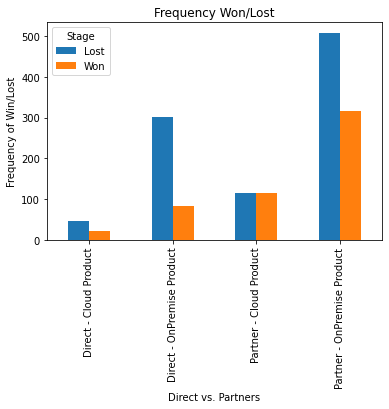

In [132]:
# win/lose vs. segment 
%matplotlib inline
pd.crosstab(df.Type,df.Stage).plot(kind='bar')
plt.title('Frequency Won/Lost')
plt.xlabel('Direct vs. Partners')
plt.ylabel('Frequency of Win/Lost')
plt.savefig('WinLost')

## Explore the Seasonality 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


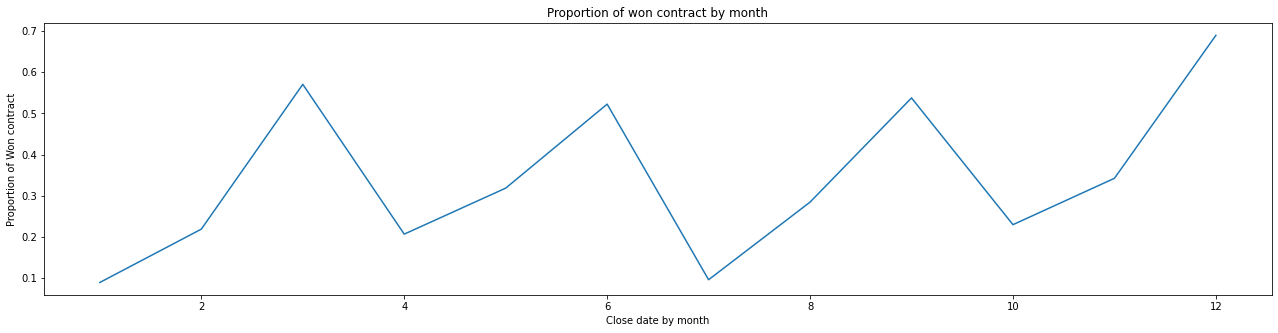

In [133]:
# Plot the won contract proportion by month
df_date_stage=df[['Close Date','Stage']]
df_date_stage['Close Date Month num']=pd.to_datetime(df_date_stage['Close Date']).dt.month
df_date_stage=pd.concat([df_date_stage,pd.get_dummies(df_date_stage.Stage,prefix='stage')],axis=1)

df_month_stage=df_date_stage.groupby(['Close Date Month num'],as_index=None).sum()
df_month_stage['won_prop']=df_month_stage['stage_Won']/(df_month_stage['stage_Won']+df_month_stage['stage_Lost'])
df_month_stage.head()

%matplotlib inline

plt.figure(figsize=(22,5))
plt.plot(df_month_stage['Close Date Month num'],df_month_stage['won_prop'])
plt.title('Proportion of won contract by month')
plt.xlabel('Close date by month')
plt.ylabel('Proportion of Won contract')
plt.savefig('WinLost vs date')

There appears to be a seasonaility. At the end of the quarter, the close rate increase.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


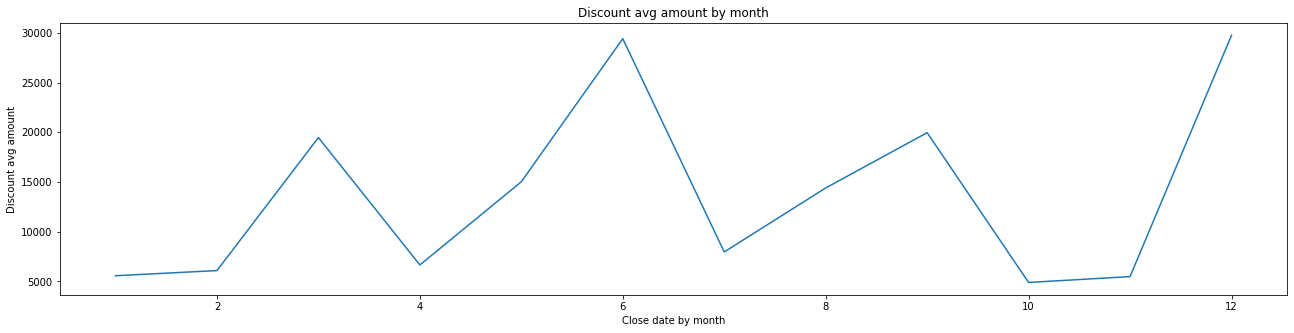

In [134]:
# Plot average discount by month
df_date_discount=df[['Close Date','discount']]
df_date_discount['Close Date Month num']=pd.to_datetime(df_date_discount['Close Date']).dt.month
df_date_discount=df_date_discount.groupby('Close Date Month num',as_index=None).mean()
%matplotlib inline
plt.figure(figsize=(22,5))
plt.plot(df_date_discount['Close Date Month num'],df_date_discount['discount'])
plt.title('Discount avg amount by month')
plt.xlabel('Close date by month')
plt.ylabel('Discount avg amount')
plt.savefig('WinLost vs date')
#There appears to be a seasonaility. at the end of the quarter, the avg discount amount increase 

The date in terms of month appears to differentiate, so we put it as a independent variable in the model.

## Modeling

Firstly build logistic regression to predict the probability of contract win. Then build optimization model to maximize total revenue. 

We evaluated the model performance by comparing optimized revenue/ actual revenue ratio.


In [135]:
df['Close Date Month']=pd.to_datetime(df['Close Date']).dt.month
df['End of Quarter']=np.where(df['Close Date Month'].isin([3,6,9,12]),1,0)

# Spliting training and test data
df['y']=np.where(df['Stage'] =='Won', 1.0,0.0)
# spliting the dataset by ID 
df_train = df.head(1200)
df_test = df.tail(305)

### 1.1 Model including avc & end of quarter as independent variables

In [136]:
# Model including acv and seasonality
y=df_train['y']
x2=df_train[['discount','amount','New Logo','Partner cloud','Partner prem','Direct cloud','Direct prem','acv','End of Quarter']]
model2 = sm.Logit(y, x2, missing='drop')
model2.fit
type(model2)
result2=model2.fit()
print(result2.summary()) #appears to be all significant 

Optimization terminated successfully.
         Current function value: 0.370624
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1121
Model:                          Logit   Df Residuals:                     1112
Method:                           MLE   Df Model:                            8
Date:                Tue, 16 Jun 2020   Pseudo R-squ.:                  0.4473
Time:                        21:09:35   Log-Likelihood:                -415.47
converged:                       True   LL-Null:                       -751.77
Covariance Type:            nonrobust   LLR p-value:                5.628e-140
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
discount         2.68e-05   5.65e-06      4.748      0.000    1.57e-05    3.79e-05
amount          1

### 1.2 Price Optimization using the model


Using these results, we want to optimize on the price
p is the amount, d is the discount

\begin{equation}
R(p)=Proba(Y=1|p,d) \times (p-d)
\end{equation}

In [139]:
# Find the opimal discount on hold-out sample using the model
# As the discount can be calculated as zero, we want to make it positive with sqrt(x^2)
x2=df_test[['discount','amount','New Logo','Partner cloud','Partner prem','Direct cloud','Direct prem','acv','End of Quarter']]
y=df_test['y']
ID=0
ID_max=len(df_test)
z=np.empty([ID_max,])
for ID in range(ID_max):
    UT=np.matmul(x2.iloc[ID,1:10],result2.params[1:10])
    b=result2.params[0]
    p=x2.iloc[ID,1]
    def revenueD(d):
    #"""This is the negative revenue function"""
      return -np.exp(UT+b*np.sqrt(d**2))/(1+np.exp(UT+b*np.sqrt(d**2)))*(p-np.sqrt(d**2))
    sol3=minimize_scalar(revenueD)
    z[ID]=sol3.x   #z is the optimal discount
print('optimal discount is:',round(np.mean(z),0),'observed discount is ',np.round(np.mean(df['discount']),0))

optimal discount is: 7240.0 observed discount is  14927.0


In [140]:
# Compute the expected revenue after optimization and compare it to the acual revenue
# xS for x star
df_test['optimal discount']=np.sqrt(z**2)
xS=df_test[['optimal discount','amount','New Logo','Partner cloud','Partner prem','Direct cloud','Direct prem','acv','End of Quarter']]
print(xS.shape,result2.params.shape)
ID=0
ID_max=len(df_test)
revOpt=np.empty([ID_max,])
while ID<=ID_max-1:
    j=0
    u=0
    UT=np.dot(xS.iloc[ID].T,result2.params[0:10].T)
    proba=np.exp(UT)/(1+np.exp(UT))
    revOpt[ID]=proba*(xS.iloc[ID,1]-z[ID])
    ID=ID+1
revOpt=np.nan_to_num(revOpt)

(305, 9) (9,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [141]:
# Calculate the ratio of the optimized expected revenue / actual revenues
df_test['Revenue']=np.where(df_test['Stage'] =='Won',df_test['net amount'] ,0.0)
round(np.sum(revOpt)/np.sum(df_test['Revenue']),3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1.604

In [142]:
# The revenue increase
round(np.sum(revOpt)-np.sum(df_test['Revenue']),3)

2948896.389

### 2.1 Final model improved with interactive terms

In [143]:
# Check the correlation
df[['discount','amount','New Logo','Partner cloud','Partner prem','Direct cloud','Direct prem','acv','billing plan year','End of Quarter']].corr()

# billing plan year has high correlation 

,discount,amount,New Logo,Partner cloud,Partner prem,Direct cloud,Direct prem,acv,billing plan year,End of Quarter
discount,1.000000,0.744895,0.229336,0.143729,-0.046708,0.027240,-0.079695,0.304594,0.183610,0.152034
amount,0.744895,1.000000,0.171924,0.232642,-0.063395,0.044192,-0.142931,0.759000,0.150175,0.109886
New Logo,0.229336,0.171924,1.000000,0.262359,-0.114549,0.111119,-0.138820,0.010098,0.065821,0.163964
Partner cloud,0.143729,0.232642,0.262359,1.000000,-0.467196,-0.092392,-0.248149,0.238617,0.056921,0.086214
Partner prem,-0.046708,-0.063395,-0.114549,-0.467196,1.000000,-0.239285,-0.642677,-0.109749,-0.061087,0.044530
Direct cloud,0.027240,0.044192,0.111119,-0.092392,-0.239285,1.000000,-0.127095,0.091443,0.003345,-0.022233
Direct prem,-0.079695,-0.142931,-0.138820,-0.248149,-0.642677,-0.127095,1.000000,-0.107158,0.011227,-0.111504
acv,0.304594,0.759000,0.010098,0.238617,-0.109749,0.091443,-0.107158,1.000000,-0.004352,-0.011090
billing plan year,0.183610,0.150175,0.065821,0.056921,-0.061087,0.003345,0.011227,-0.004352,1.000000,0.092949
End of Quarter,0.152034,0.109886,0.163964,0.086214,0.044530,-0.022233,-0.111504,-0.011090,0.092949,1.000000


In [144]:
# The final logistic regression model improved by seasonality and interactive terms
import statsmodels.formula.api as smf
formula = "y ~ 0+discount+amount+Q('New Logo')+Q('Partner cloud')+Q('Partner prem')+Q('Direct cloud')+Q('Direct prem')\
+Q('acv')+Q('End of Quarter')+discount:Q('New Logo')+discount:Q('Partner cloud')+discount:Q('Partner prem')+discount:Q('Direct cloud')+\
discount:Q('Direct prem')+discount:Q('End of Quarter')"
model_glm = smf.glm(formula = formula, data=df_train, family=sm.families.Binomial(),missing='drop')
result_glm = model_glm.fit()
print(result_glm.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:942: RuntimeWarning: divide by zero encountered in true_divide
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:943: RuntimeWarning: divide by zero encountered in log
  n * np.log(1 - mu)) * var_weights
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:943: RuntimeWarning: invalid value encountered in add
  n * np.log(1 - mu)) * var_weights


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1121
Model:                            GLM   Df Residuals:                     1107
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Tue, 16 Jun 2020   Deviance:                          nan
Time:                        21:10:34   Pearson chi2:                 8.84e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
discount        

### 2.2 Price opimization using final model
Using these results, we want to optimize on the price
p is the amount, d is the discount

\begin{equation}
R(p)=Proba(Y=1|p,d) \times (p-d)
\end{equation}

In [145]:
x2_interaction=df_test[['discount','amount','New Logo','Partner cloud','Partner prem','Direct cloud','Direct prem','acv','End of Quarter']]

ID=0
ID_max=len(x2_interaction)
z=[]
for ID in range(ID_max):
    UT=np.dot(x2_interaction.iloc[ID,1:9],result_glm.params[1:9])
    UT2=np.dot(x2_interaction.iloc[ID,2:7],result_glm.params[9:14])+x2_interaction.iloc[ID,8]*result_glm.params[14] #skipped acv
    b=result_glm.params[0]
    p=x2_interaction.iloc[ID,1]
    def revenueD(d):
    #"""This is the negative revenue function"""
      return -np.exp(UT+(UT2+b)*np.sqrt(d**2))/(1+np.exp(UT+(UT2+b)*np.sqrt(d**2)))*(p-np.sqrt(d**2))
    sol3=minimize_scalar(revenueD)
    z.append(sol3.x)
z = np.array(z)  # z is the optimal discount
print('optimal discount is:',round(np.mean(z),0),'observed discount is ',np.round(np.mean(df['discount']),0))

optimal discount is: 6602.0 observed discount is  14927.0


In [146]:
# Calculate the ratio of the optimized expected revenue / actual revenues
x2_interaction['optimal discount']=np.sqrt(z**2)
Summary_Opt=df_test
Summary_Opt['optimal discount']=np.sqrt(z**2)
xS=x2_interaction[['optimal discount','amount','New Logo','Partner cloud','Partner prem','Direct cloud','Direct prem','acv','End of Quarter']]

print(xS.shape,result_glm.params.shape)
ID=0
ID_max=len(x2_interaction)
revOpt=np.empty([ID_max,])
for ID in range(ID_max):
    dis=xS.iloc[ID,0]
    UT=np.dot(xS.iloc[ID,0:9],result_glm.params[0:9])
    UT2=np.dot(xS.iloc[ID,2:7],result_glm.params[9:14])+xS.iloc[ID,8]*result_glm.params[14]  #skipped acv
    proba=np.exp(UT+UT2*np.sqrt(dis**2))/(1+np.exp(UT+UT2*np.sqrt(dis**2)))
    revOpt[ID]=proba*(xS.iloc[ID,1]-dis)
revOpt=np.nan_to_num(revOpt);

(305, 9) (15,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [147]:
# Final optimization result
x2_interaction['Revenue']=np.where(df_test['Stage'] =='Won',df_test['net amount'] ,0.0)
round(np.sum(revOpt)/np.sum(x2_interaction['Revenue']),3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1.612

In [148]:
# Optimized revenue
round(np.sum(revOpt)-np.sum(df_test['Revenue']),3)

2986902.973

## Summary

In [149]:
Summary_Opt.columns

Index(['ID', 'Close Date', 'Created Date', 'New Logo', 'Type', 'Stage',
       'Billing Plan', ' ACV ', ' Discount Amount ', ' Amount ',
       ' Net Amount ', 'Partner cloud', 'Partner prem', 'Direct cloud',
       'Direct prem', 'amount', 'acv', 'net amount', 'billing plan year',
       'discount', 'depth', 'Close Date Month', 'End of Quarter', 'y',
       'optimal discount', 'Revenue'],
      dtype='object')

In [150]:
Summary_Opt['Revenue_optimized']=revOpt
Summary_Opt['depth_optimized']=Summary_Opt['optimal discount']/Summary_Opt['amount']
Summary_Opt['depth']=Summary_Opt['discount']/Summary_Opt['amount']
Summary_Opt['Revenue_optimized']=revOpt
Summary_Opt['Increased Revenue']=Summary_Opt['Revenue_optimized']-Summary_Opt['Revenue']
# Type
round(Summary_Opt[['Type','depth','depth_optimized','amount','discount','Increased Revenue']].groupby('Type').mean(),2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,depth,depth_optimized,amount,discount,Increased Revenue
Type,,,,,
Direct - Cloud Product,0.13,0.15,64117.65,12471.76,10767.75
Direct - OnPremise Product,0.04,0.00,33464.41,2937.01,2724.45
Partner - Cloud Product,0.22,0.05,141035.94,52629.22,37273.97
Partner - OnPremise Product,0.09,0.14,52695.51,10492.98,8531.55


In [151]:
# New logo 
round(Summary_Opt[['New Logo','depth','depth_optimized','amount','discount','Increased Revenue']].groupby('New Logo').mean(),2)

,depth,depth_optimized,amount,discount,Increased Revenue
New Logo,,,,,
0,0.05,0.08,42581.66,5617.06,4365.66
1,0.15,0.07,75465.39,22536.55,17434.49


In [152]:
# End of quarter (Seasonality)
round(Summary_Opt[['End of Quarter','depth','depth_optimized','amount','discount','Increased Revenue']].groupby('End of Quarter').mean(),2)

,depth,depth_optimized,amount,discount,Increased Revenue
End of Quarter,,,,,
0,0.05,0.09,47317.96,6096.94,3231.20
1,0.17,0.04,74158.21,25733.13,22884.31
